In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms

In [24]:
class MNISTDataset(Dataset):
    def __init__(self, root='data/', train=True, transforms=None):
        self.data = datasets.MNIST(root=root, train=train, transform=transforms, download=True)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image, label
    
    def get_datas(self):
        return self.data.data
    
    def get_labels(self):
        return self.data.targets.cpu().numpy()

In [25]:
train_dataset = MNISTDataset(train=True, transforms=transforms.ToTensor())
test_dataset = MNISTDataset(train=False, transforms=transforms.ToTensor())

In [26]:
class Softmax(nn.Module):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.lr = lr
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))
    
    def forward(self, X):
        return self.net(X)

In [27]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [19]:
model = Softmax(num_outputs=10, lr=0.1)
print(model.state_dict())

OrderedDict([('net.1.weight', <UninitializedParameter>), ('net.1.bias', <UninitializedParameter>)])


In [28]:
# Metrics
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()
batch_size = 256

In [29]:
datas = train_dataset.get_datas()
labels = train_dataset.get_labels()

In [ ]:
epochs = 10
Loss = []
acc = []

numth_train = 0

for fold, (train_idx, val_idx) in enumerate(skf.split(datas, labels)):
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    numth_train += 1
    print('TRAIN TIME: {}'.format(numth_train))

    for epoch in range(epochs):
        epoch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images.view(-1, 28*28))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        Loss.append(epoch_loss / len(train_loader))
        correct = 0
        for images, labels in val_loader:
            outputs = model(images.view(-1, 28*28))
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum()
        accuracy = 100 * correct.item() / len(val_subset)
        acc.append(accuracy)
        print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, Loss[-1], accuracy))

40000
20000
TRAIN TIME: 1
Epoch: 0. Loss: 0.8265096936256263. Accuracy: 86.615
Epoch: 1. Loss: 0.47770247546730527. Accuracy: 88.43
Epoch: 2. Loss: 0.4194439523349142. Accuracy: 89.22
Epoch: 3. Loss: 0.39039529613248863. Accuracy: 89.635
Epoch: 4. Loss: 0.3720496006452354. Accuracy: 89.935
Epoch: 5. Loss: 0.3590462392872306. Accuracy: 90.225
Epoch: 6. Loss: 0.34917081987402243. Accuracy: 90.425
Epoch: 7. Loss: 0.34131810534152257. Accuracy: 90.6
Epoch: 8. Loss: 0.3348656592855028. Accuracy: 90.725
Epoch: 9. Loss: 0.32943199090896896. Accuracy: 90.845
40000
20000
TRAIN TIME: 2
Epoch: 0. Loss: 0.32810776685453524. Accuracy: 90.98
Epoch: 1. Loss: 0.3233187448257094. Accuracy: 91.02
Epoch: 2. Loss: 0.3193027963683863. Accuracy: 91.165
Epoch: 3. Loss: 0.31580545558671286. Accuracy: 91.245
Epoch: 4. Loss: 0.3127033203650432. Accuracy: 91.3
Epoch: 5. Loss: 0.309917957539771. Accuracy: 91.365
Epoch: 6. Loss: 0.3073935727025293. Accuracy: 91.385
Epoch: 7. Loss: 0.30508833668034546. Accuracy: 91

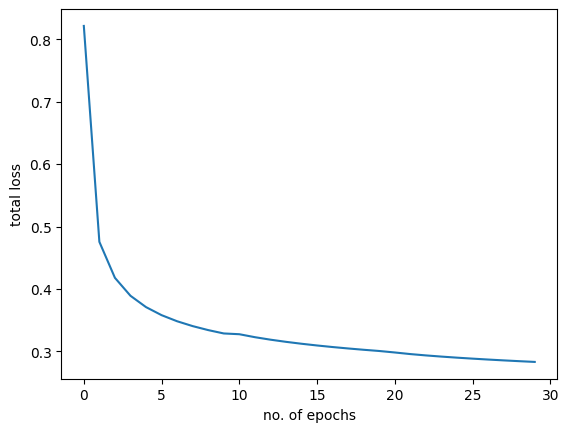

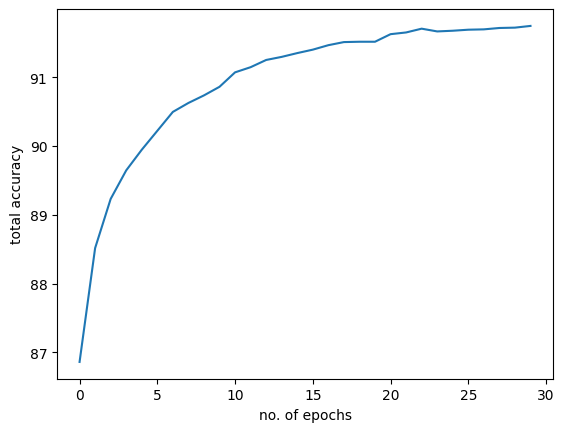

In [11]:
plt.plot(Loss)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.show()
 
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

In [12]:
def predict(model, test_dataset):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, labels in test_dataset:
            outputs = model(images.view(-1, 28*28))
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted)
    return predictions

In [13]:
predictions = predict(model, test_dataset)
print(predictions)

[tensor([7]), tensor([2]), tensor([1]), tensor([0]), tensor([4]), tensor([1]), tensor([4]), tensor([9]), tensor([6]), tensor([9]), tensor([0]), tensor([6]), tensor([9]), tensor([0]), tensor([1]), tensor([5]), tensor([9]), tensor([7]), tensor([3]), tensor([4]), tensor([9]), tensor([6]), tensor([6]), tensor([5]), tensor([4]), tensor([0]), tensor([7]), tensor([4]), tensor([0]), tensor([1]), tensor([3]), tensor([1]), tensor([3]), tensor([6]), tensor([7]), tensor([2]), tensor([7]), tensor([1]), tensor([2]), tensor([1]), tensor([1]), tensor([7]), tensor([4]), tensor([2]), tensor([3]), tensor([5]), tensor([1]), tensor([2]), tensor([4]), tensor([4]), tensor([6]), tensor([3]), tensor([5]), tensor([5]), tensor([6]), tensor([0]), tensor([4]), tensor([1]), tensor([9]), tensor([5]), tensor([7]), tensor([8]), tensor([9]), tensor([2]), tensor([7]), tensor([4]), tensor([7]), tensor([4]), tensor([3]), tensor([0]), tensor([7]), tensor([0]), tensor([2]), tensor([9]), tensor([1]), tensor([7]), tensor([3])

In [18]:
datas_test = test_dataset.get_datas()
labels_test = test_dataset.get_labels()

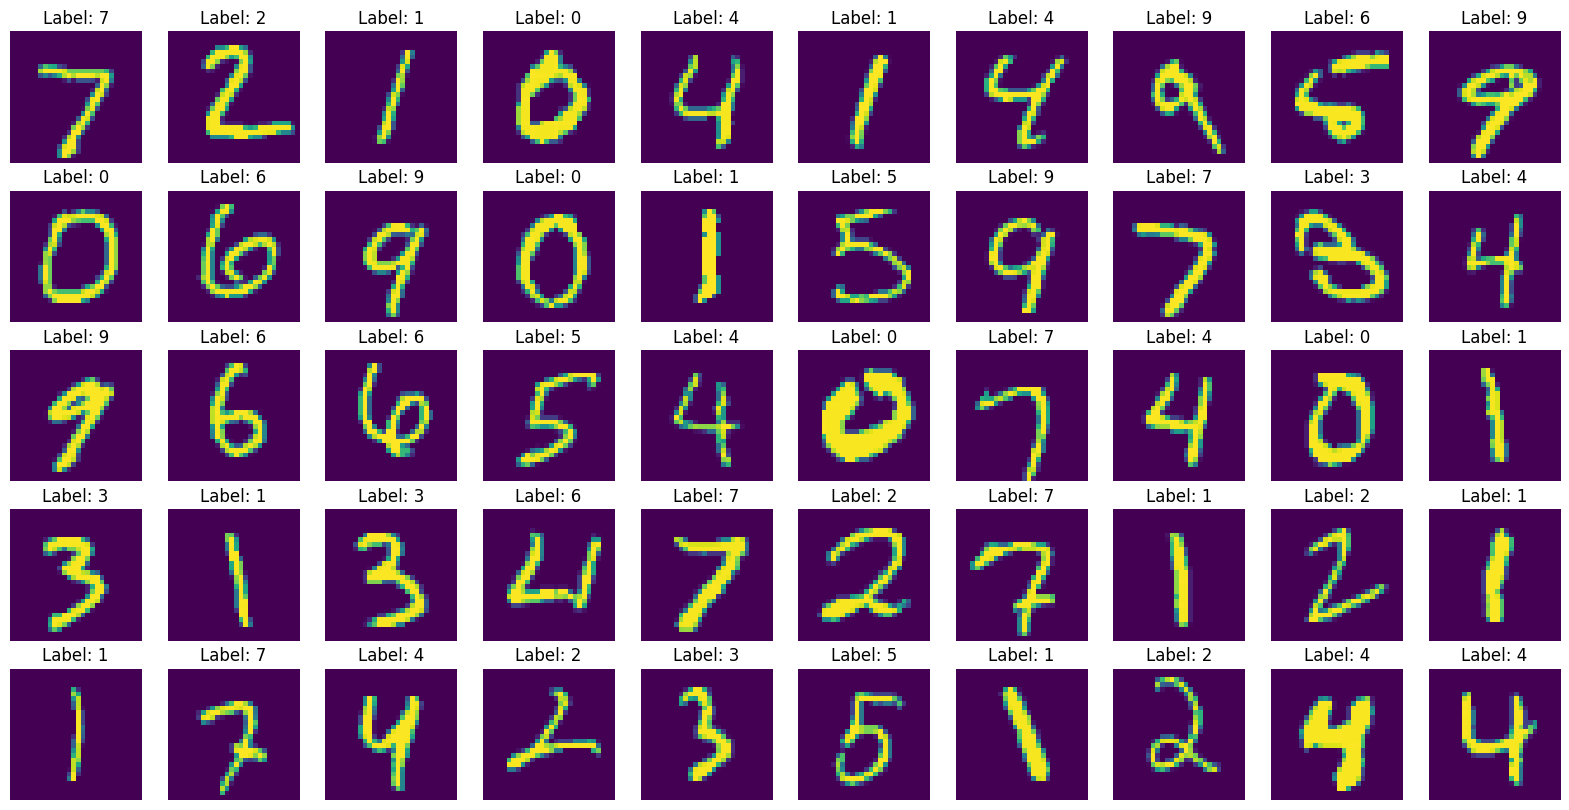

In [17]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(datas_test[i].squeeze(0))
    ax.set_title(f"Label: {predictions[i].item()}")
    ax.axis("off")

plt.show()

In [28]:
preds = np.array(predictions, dtype=np.int32)
acc_test = float((preds == labels_test).sum()) / len(labels_test)
print('Test accuracy: {}'.format(acc_test))

Test accuracy: 0.9206


C:\Users\Admin\AppData\Local\Temp\ipykernel_19248\3859846017.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  preds = np.array(predictions, dtype=np.int32)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19248\3859846017.py:1: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  preds = np.array(predictions, dtype=np.int32)
